In [1]:
# !pip install matplotlib

## TCC

## 1 - Importando bibliotecas

In [2]:
# Instalar a biblioteca TALIB para indicadores técnicos de mercado financeiro como explicado no site: https://blog.quantinsti.com/install-ta-lib-python/

import datetime
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import dates
import chart_studio.plotly as py
from plotly import tools
from plotly.offline import download_plotlyjs,plot,iplot 
import plotly.graph_objs as go
import plotly.figure_factory as ff

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=True)
%reload_ext autoreload
%autoreload 2

import investpy
from pycaret.classification  import *
from pycaret.utils import check_metric
import os.path
import talib
import networkx as nx
import xgboost as xgb
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Teste de Dickey-Fuller
from statsmodels.tsa.stattools import adfuller

from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score, classification_report, cohen_kappa_score
from pycaret.utils import enable_colab
enable_colab()


import seaborn as sns
sns.color_palette("mako", as_cmap=True)

#configura parâmetros da biblioteca pandas
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1500)
pd.set_option('display.max_rows', 500)
pd.set_option('mode.chained_assignment', None)


%matplotlib inline

Colab mode enabled.


## 2 - Importando base de dados

In [3]:
inicio = '02/01/2004'
fim = '30/06/2021'
# Cotação da taxa de câmbio
dolar = investpy.get_currency_cross_historical_data(currency_cross='USD/BRL', 
                                                    from_date=inicio, to_date=fim)    
# Dólar Índice
dxy = investpy.indices.get_index_historical_data(index='US Dollar Index', country='united states', 
                                                 from_date=inicio, to_date=fim)
# Índice Bovespa
ibov = investpy.indices.get_index_historical_data(index='Bovespa', country='brazil', 
                                                  from_date=inicio, to_date=fim) 
# Índice Volatilidade S&P 500 VIX
vix = investpy.indices.get_index_historical_data(index='S&P 500 VIX', country='united states', 
                                                 from_date=inicio, to_date=fim)     

## 3 - Merge e tratamento dos Dataframes

In [4]:
# Renomeando as colunas
dolar = dolar.rename(columns={'Open':'dolar_open', 'High': 'dolar_high', 'Low': 'dolar_low', 'Close': 'dolar_close'})
dxy = dxy.rename(columns={'Open':'dxy_open', 'High': 'dxy_high', 'Low': 'dxy_low', 'Close': 'dxy_close'})
ibov = ibov.rename(columns={'Open':'ibov_open', 'High': 'ibov_high', 'Low': 'ibov_low', 'Close': 'ibov_close'})
vix = vix.rename(columns={'Open':'vix_open', 'High': 'vix_high', 'Low': 'vix_low', 'Close': 'vix_close'})

# Eliminando colunas não utilizadas(Currency) e vazias(Volume)
dolar = dolar.drop(columns=['Currency'])
dxy = dxy.drop(columns=['Volume', 'Currency'])
ibov = ibov.drop(columns=['Volume', 'Currency'])
vix = vix.drop(columns=['Volume', 'Currency'])

In [5]:
# Realizando o Left Join, merge das bases de dados
data = dolar.merge(dxy, on='Date', how='left')
data = data.merge(ibov, on='Date', how='left')
data = data.merge(vix, on='Date', how='left')

### 3.1 - Verificando e tratando dados faltantes

In [6]:
data.isna().sum()

dolar_open       0
dolar_high       0
dolar_low        0
dolar_close      0
dxy_open        27
dxy_high        27
dxy_low         27
dxy_close       27
ibov_open      232
ibov_high      232
ibov_low       232
ibov_close     232
vix_open       153
vix_high       153
vix_low        153
vix_close      153
dtype: int64

In [7]:
# Conta os dados faltantes
pd.DataFrame(data.isnull().sum()).transpose()

dolar_open  dolar_high  dolar_low  dolar_close  dxy_open  dxy_high  dxy_low  dxy_close  ibov_open  ibov_high  ibov_low  ibov_close  vix_open  vix_high  vix_low  vix_close
0           0           0          0            0        27        27       27         27        232        232       232         232       153       153      153        153

In [8]:
# Utilizando interpolação linear para preencher os dados faltantes
data = data.interpolate(method='linear', limit_direction='forward')

In [9]:
# Verifica se há dados faltantes
pd.DataFrame(data.isnull().sum()).transpose()

dolar_open  dolar_high  dolar_low  dolar_close  dxy_open  dxy_high  dxy_low  dxy_close  ibov_open  ibov_high  ibov_low  ibov_close  vix_open  vix_high  vix_low  vix_close
0           0           0          0            0         0         0        0          0          0          0         0           0         0         0        0          0

## 4 - Análise Exploratória dos Dados - Parte I

In [10]:
pd.options.display.float_format = "{:.2f}".format
data.describe()

dolar_open  dolar_high  dolar_low  dolar_close  dxy_open  dxy_high  dxy_low  dxy_close  ibov_open  ibov_high  ibov_low  ibov_close  vix_open  vix_high  vix_low  vix_close
count     4560.00     4560.00    4560.00      4560.00   4560.00   4560.00  4560.00    4560.00    4560.00    4560.00   4560.00     4560.00   4560.00   4560.00  4560.00    4560.00
mean         2.78        2.80       2.76         2.78     87.07     87.37    86.76      87.07   60293.30   60921.25  59678.48    60322.82     19.01     19.94    18.09      18.89
std          1.05        1.06       1.04         1.05      7.81      7.81     7.80       7.81   23398.67   23572.27  23231.59    23412.67      9.13      9.82     8.42       9.09
min          1.54        1.54       1.53         1.54     71.33     71.69    70.70      71.33   17607.00   18387.00  17601.00    17604.00      9.01      9.31     8.56       9.14
25%          1.98        1.99       1.96         1.98     80.50     80.71    80.24      80.48   47003.00   47457.75  46407.12    46963.38     13.22     13.74    12.74      13.14
50%          2.35        2.38       2.33         2.35     86.08     86.47    85.69      86.05   57362.00   57968.00  56842.00    57380.00     16.18     16.88    15.46      16.07
75%          3.31        3.33       3.29         3.31     94.52     94.77    94.13      94.49   69021.50   69574.83  68465.25    69044.50     21.89     22.98    20.86      21.59
max          5.92        5.97       5.82         5.89    103.26    103.82   103.03     103.30  130776.00  131190.00 129526.00   130776.00     82.69     89.53    72.76      82.69

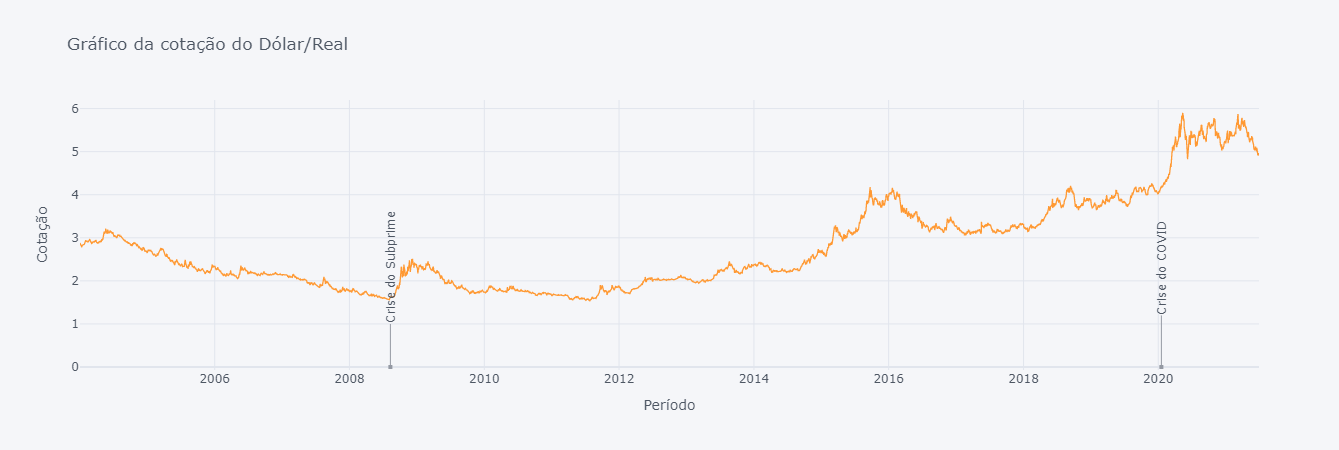

In [11]:
anotacoes = {pd.to_datetime('2008-08-10'): 'Crise do Subprime', pd.to_datetime('2020-01-18'): 'Crise do COVID'}

fig = data.dolar_close.iplot(kind='line',xTitle='Período',yTitle='Cotação',title='Gráfico da cotação do Dólar/Real',
                            annotations=anotacoes)



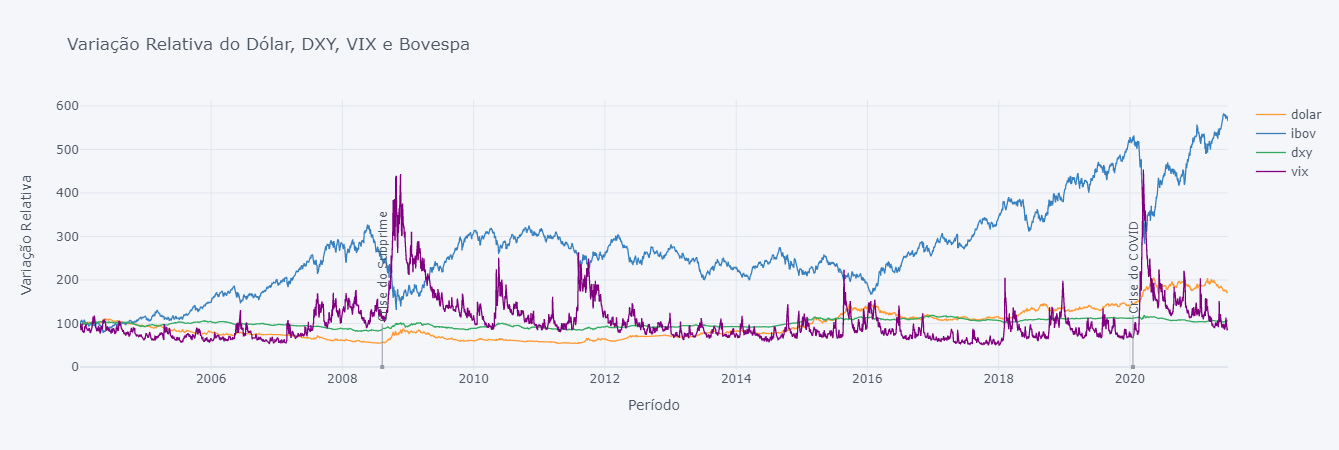

In [12]:
#Variação Relativa do Dólar, DXY, VIX e Bovespa partindo do 100
normalizado = dolar.copy()
normalizado['dolar'] = data.dolar_close.div(data.dolar_close.iloc[0]).mul(100)
normalizado['ibov'] = data.ibov_close.div(data.ibov_close.iloc[0]).mul(100)
normalizado['dxy'] = data.dxy_close.div(data.dxy_close.iloc[0]).mul(100)
normalizado['vix'] = data.vix_close.div(data.vix_close.iloc[0]).mul(100)

normalizado[['dolar', 'ibov', 'dxy', 'vix']].iplot(kind='line',xTitle='Período',yTitle='Variação Relativa',title='Variação Relativa do Dólar, DXY, VIX e Bovespa',
                                                         annotations=anotacoes)

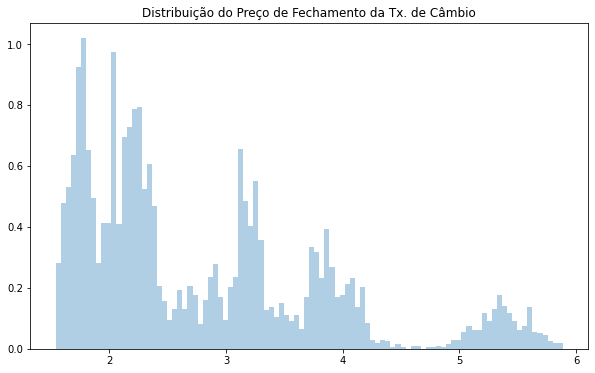

In [13]:
# Distribuição do valor da Tx. de Câmbio
config = dict(histtype = 'stepfilled', alpha = 0.35, density = True, bins = 100)
plt.figure(figsize = (10,6))
plt.hist(data.dolar_close, **config, label = "Variação do Dólar/Real")
# plt.legend(loc = "upper right", frameon = True, ncol = 2, fancybox = True, framealpha = 0.95, shadow = True, borderpad = 1)
plt.title("Distribuição do Preço de Fechamento da Tx. de Câmbio")
plt.savefig('distribuicaoPrecoDolar.png')

In [14]:
# Teste de Dickey-Fuller
def teste_dickeyF(coluna):
    
    coluna = coluna.dropna()
    # Definindo a a média e desvio padão para 12 dias
    rolmean = coluna.rolling(12).mean()
    rolstd = coluna.rolling(12).std()
    
    plt.figure(figsize = (22,8))
    orig = plt.plot(coluna, color='blue',label='Valor Original')
    mean = plt.plot(rolmean, color='red', label='Média Móvel')
    std = plt.plot(rolstd, color='black', label = 'Desvio Padrão Móvel')
    plt.legend(loc='best')
    plt.title('Média Móvel & Desvio Padrão')
    plt.savefig("DF.png")
    plt.show()
    
    
    #Perform Dickey-Fuller test:
    print('Resultado do Teste de Dickey-Fuller:')
    dftest = adfuller(coluna)
    dfoutput = pd.Series(dftest[0:4], index=['Teste','p-valor','Lags','Número de observações usadas'])
    for key,value in dftest[4].items():
        dfoutput['Valor crítico (%s)'%key] = value
    print(dfoutput)


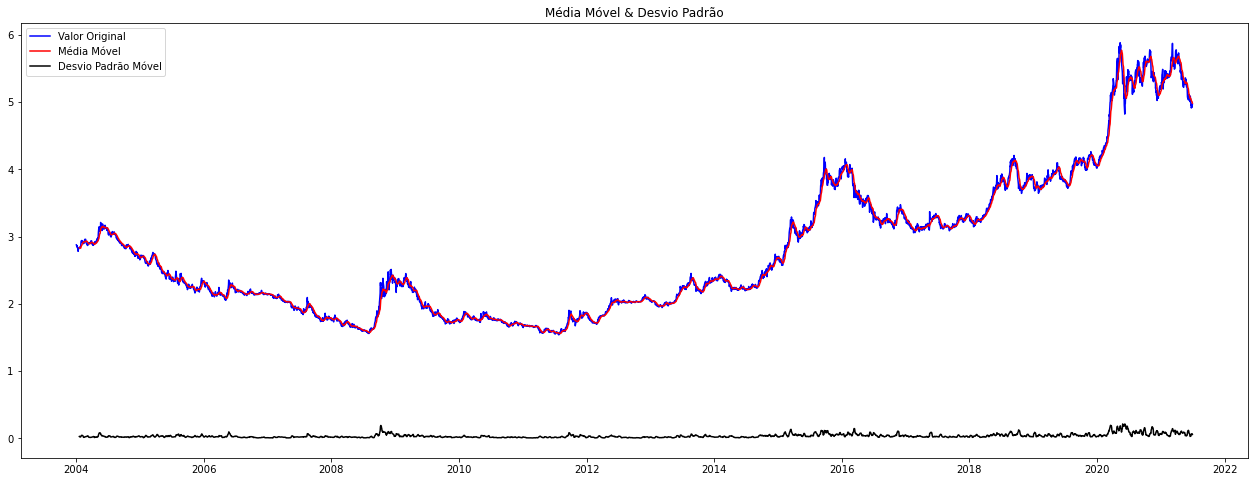

Resultado do Teste de Dickey-Fuller:
Teste                             0.16
p-valor                           0.97
Lags                             25.00
Número de observações usadas   4534.00
Valor crítico (1%)               -3.43
Valor crítico (5%)               -2.86
Valor crítico (10%)              -2.57
dtype: float64


In [15]:
teste_dickeyF(data.dolar_close) # Teste de Dickey-Fuller

## 5 - Feature Engineering - Parte I 

In [16]:
periodos=1

# Variação do fechamento anteior com o atual
data["ganhoDolar"] =  data.dolar_close.pct_change(periodos)
# Desloca o ganho do próximo dia para o dia atual para saber se é alta/baixa o próximo dia(Será o nosso alvo)
data["ganhoFuturo"] = data.ganhoDolar.shift(-periodos)


# Calcula a variação em pontos do dia
data['PontosDia'] = data.dolar_close.diff(periodos)*1000
# Desloca o próximo dia para o dia atual
data.insert(16, 'Pontos', data["PontosDia"].shift(-periodos))

# Dias da Semana
days = ["2-Segunda", "3-Terça", "4-Quarta", "5-Quinta", "6-Sexta"]
data['diasemana'] = pd.to_datetime(data.index).dayofweek
data.insert(17, 'diasemananome', data.diasemana.apply(lambda x: days[x]))

# Caso o dia for de Alta, então 1, se não -1(baixa)
data["altabaixa"] = np.where(data.ganhoDolar > 0, 1, -1)
data.insert(17, 'altabaixanome', np.where(data.ganhoDolar > 0, 'Alta', 'Baixa'))

# Elimina os dados faltantes inseridos pelos deslocamentos
data = data.dropna()



In [17]:
data["variacaodolar"] = data.dolar_close/data.dolar_close.shift(periodos)
data["variacaodxy"] = data["dxy_close"]/data["dxy_close"].shift(periodos)
data["variacaoibov"] = data["ibov_close"]/data["ibov_close"].shift(periodos)
data["variacaovix"] = data["vix_close"]/data["vix_close"].shift(periodos)

## 6 - Análise Exploratória dos Dados - Parte II

### 6.1 - Análise estatística da base de Treinamento

In [18]:
inicioValidacao = pd.to_datetime('2016-01-01') + datetime.timedelta(days=-1)
dataanalise = data[inicio  : inicioValidacao]

### 6.2 - Análise da Distribuição dos retornos diários do Dólar/Real

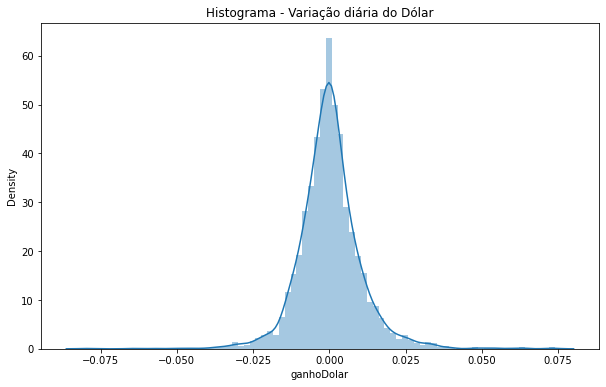

In [19]:
# Gráfico da distribuição dos dias que foram de Alta e Baixa
plt.figure(figsize = (10,6))
x = sns.distplot(dataanalise.ganhoDolar, bins= 80).set(title='Histograma - Variação diária do Dólar')
plt.savefig("distribuicaoGanhodolar.png")
plt.show()

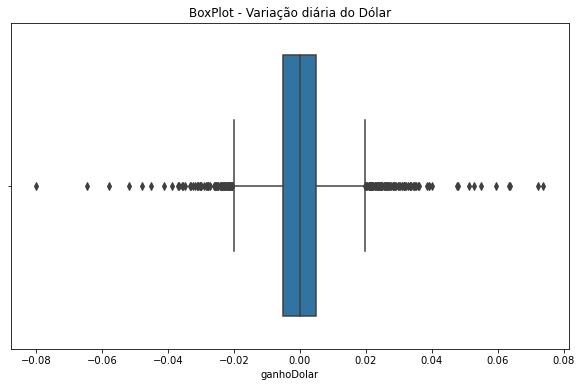

In [20]:
# Boxplot do retorno diário do 'Dólar/Real
plt.figure(figsize = (10,6))
ax = sns.boxplot("ganhoDolar", orient="h", data=dataanalise).set(title='BoxPlot - Variação diária do Dólar')
plt.savefig("boxplotGanhodolar.png")

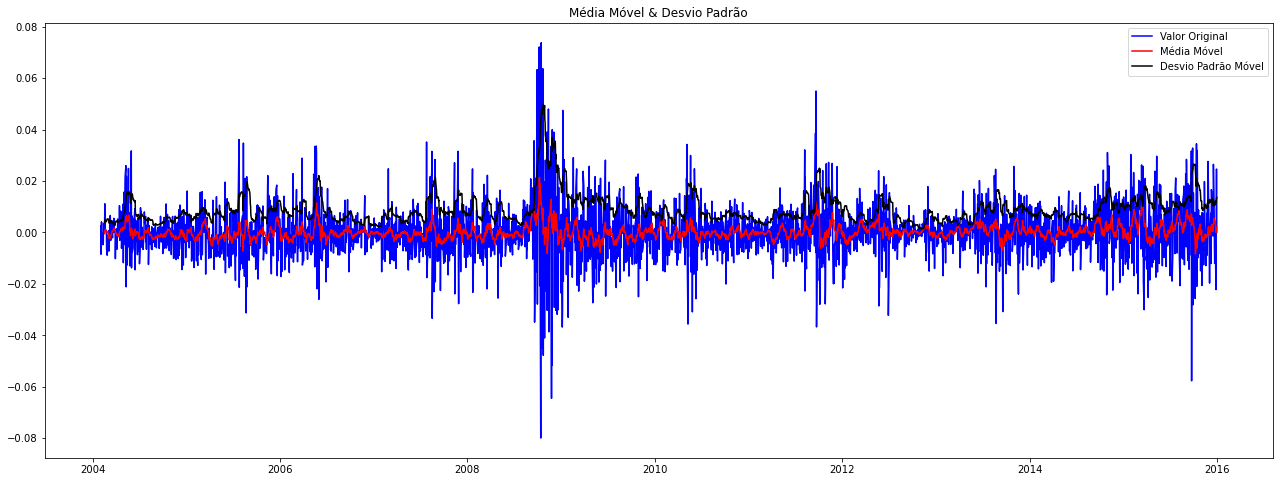

Resultado do Teste de Dickey-Fuller:
Teste                           -12.20
p-valor                           0.00
Lags                             17.00
Número de observações usadas   3091.00
Valor crítico (1%)               -3.43
Valor crítico (5%)               -2.86
Valor crítico (10%)              -2.57
dtype: float64


In [21]:
# Teste de Dickey-Fuller para verificar a estacionariedade do Retorno diário do Dolar/Real
teste_dickeyF(dataanalise.ganhoDolar)

### 6.3 - Histograma da distribuição dos dias de Alta e Baixa

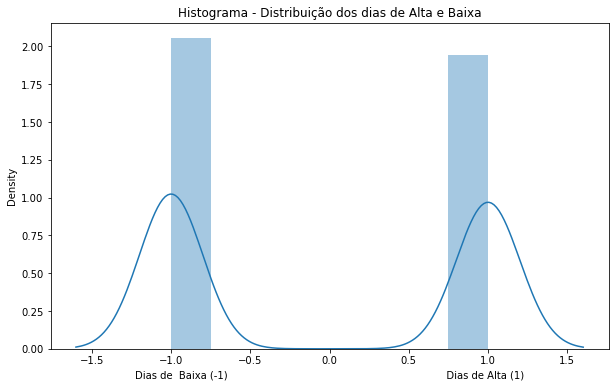

In [22]:
# Gráfico da distribuição dos dias que foram de Alta e Baixa
plt.figure(figsize = (10,6))
sns.distplot(dataanalise.altabaixa).set(xlabel='Dias de  Baixa (-1)                                                                      Dias de Alta (1)', title='Histograma - Distribuição dos dias de Alta e Baixa')
plt.savefig("distribuicaoAltaBaixa.png")

In [23]:
data.groupby(['altabaixa'])['dolar_close'].count()

altabaixa
-1    2315
 1    2243
Name: dolar_close, dtype: int64

### 6.4 - Reta da Regressão

#### 6.4.1 - Ganho do Dia X Ganho do Dia Seguinte

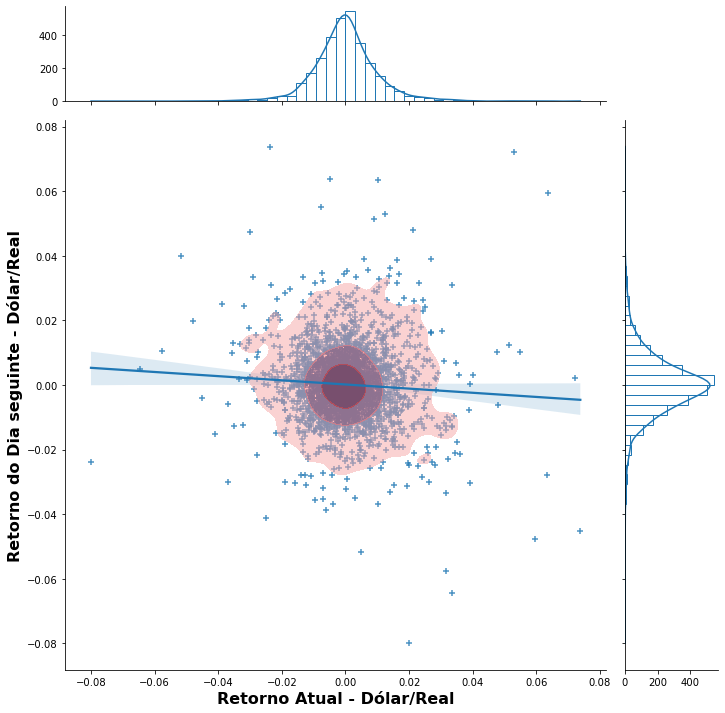

In [24]:
g = sns.jointplot(data=dataanalise, x='ganhoDolar', y='ganhoFuturo', kind='reg', marginal_ticks=True, height=10, ratio=5, palette='Set1', marker="+", marginal_kws=dict(bins=50, fill=False));
g.set_axis_labels('x', 'y', fontsize=16)
g.ax_joint.set_xlabel('Retorno Atual - Dólar/Real', fontweight='bold')
g.ax_joint.set_ylabel('Retorno do Dia seguinte - Dólar/Real', fontweight='bold')
g.plot_joint(sns.kdeplot, color='r', zorder=1, levels=4, fill=True, alpha=.5, legend=False);
g.savefig("regressaoGanhos.png")

#### 6.4.2 Variação Dólar/Real X Variação DXY X Variação VIX X Variação iBov

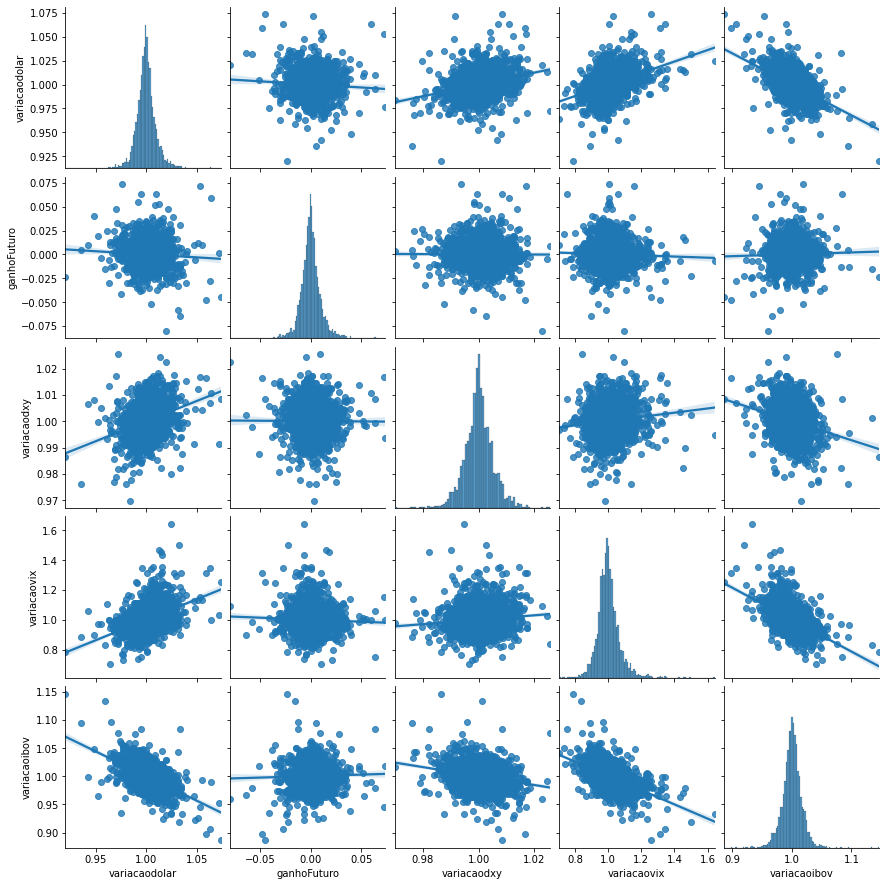

In [25]:
# Gráfico de dispersão dos ativos com reta de regressão
g = sns.pairplot(dataanalise[['variacaodolar', 'ganhoFuturo','variacaodxy','variacaovix', 'variacaoibov']], kind='reg')
g.savefig("pairPlot.png")

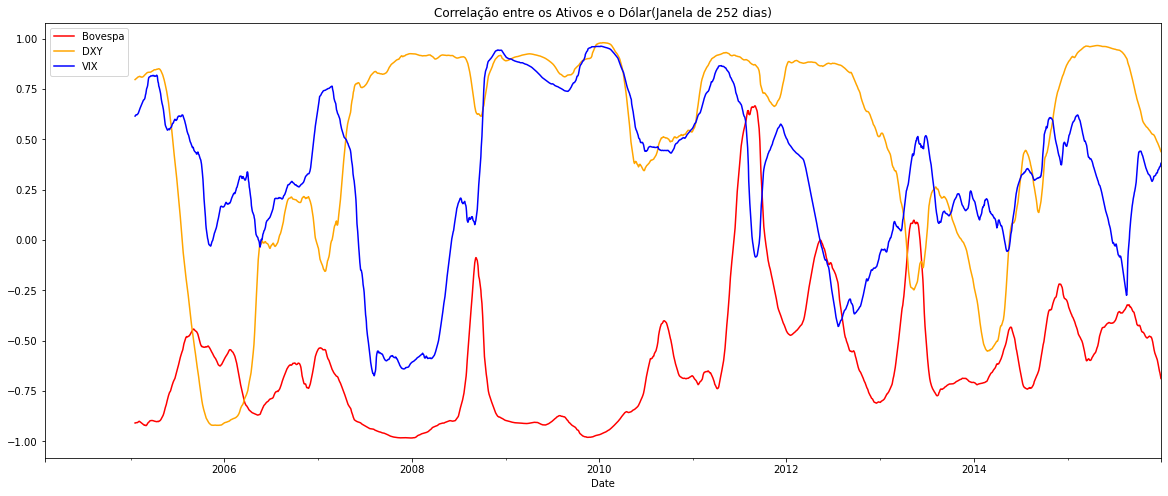

In [26]:
# Calculando a correlação entre os Ativos e o Dólar, utilizando a janela de 252 dias , aproximadamente 1 ano de mercado
plt.figure(figsize = (20,8))
dataanalise.dolar_close.rolling(252).corr(dataanalise.ibov_close).plot(color='red',label='Bovespa');
dataanalise.dolar_close.rolling(252).corr(dataanalise.dxy_close).plot(color='orange',label='DXY');
dataanalise.dolar_close.rolling(252).corr(dataanalise.vix_close).plot(color='blue',label='VIX');
plt.title('Correlação entre os Ativos e o Dólar(Janela de 252 dias)')
plt.legend(loc='best')
plt.savefig("CorrelacaoAtivos252.png")
    
    

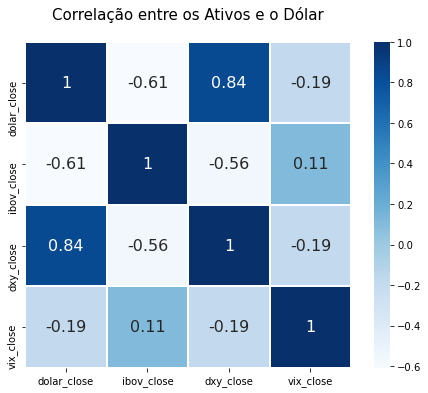

In [27]:
colormap = plt.cm.magma
datacor = dataanalise[['dolar_close', 'ibov_close', 'dxy_close', 'vix_close']]
plt.figure(figsize = (8,6))
plt.title('Correlação entre os Ativos e o Dólar', y=1.05, size=15)
sns.heatmap(datacor.corr(),linewidths=0.1,vmax=1.0, square=True, 
           linecolor='white', annot=True, cmap="Blues", annot_kws={"size": 16})
plt.savefig("CorrelacaoAtivos.png")


#### 6.4.3 - Distribuição dos ganhos por dia da semana

##### 6.4.3.1 - Distribuição de alta/baixa por dia da semana

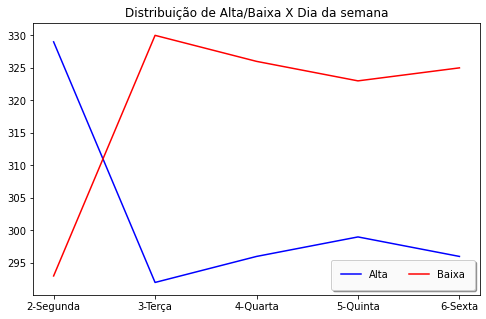

In [28]:
plt.figure(figsize = (8,5))
plt.plot(pd.crosstab(dataanalise.diasemananome, dataanalise.altabaixanome))
plt.gca().get_lines()[0].set_color("blue")
plt.gca().get_lines()[1].set_color("red")
plt.legend(('Alta', 'Baixa'),loc = "lower right", frameon = True, ncol = 2, fancybox = True, framealpha = 0.95, shadow = True, borderpad = 1)
plt.title("Distribuição de Alta/Baixa X Dia da semana");
plt.savefig("disrtibuicaoAltaBaixa.png")

##### 6.4.3.2 - Média dos Retornos das Altas/Baixas X Dia da semana

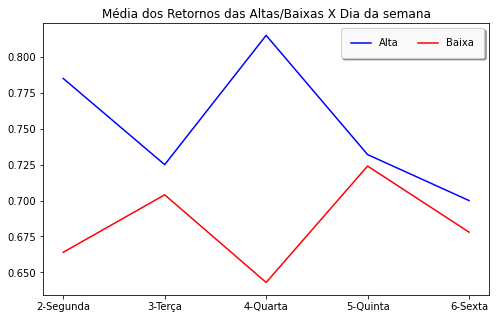

In [29]:
altamean = pd.DataFrame(round((dataanalise[dataanalise.ganhoDolar>0].groupby(['diasemananome'])['ganhoDolar'].mean()),5)*100)
baixamean = pd.DataFrame(abs(round((dataanalise[dataanalise.ganhoDolar<=0].groupby(['diasemananome'])['ganhoDolar'].mean()),5)*100))
d = pd.concat([altamean, baixamean], axis=1)
d = d.rename(columns={0:'Alta', 1: 'Baixa'})

plt.figure(figsize = (8,5))
plt.plot(d)
plt.gca().get_lines()[0].set_color("blue")
plt.gca().get_lines()[1].set_color("red")
plt.legend(('Alta', 'Baixa'),loc = "upper right", frameon = True, ncol = 2, fancybox = True, framealpha = 0.95, shadow = True, borderpad = 1)
plt.title("Média dos Retornos das Altas/Baixas X Dia da semana");
plt.savefig("disrtibuicaoAltaBaixaMedia.png")

##### 6.4.3.3 - Reta da Regressão - Ganho do Dia X Ganho do Dia Seguinte X Dia da Semana X Alta/Baixa

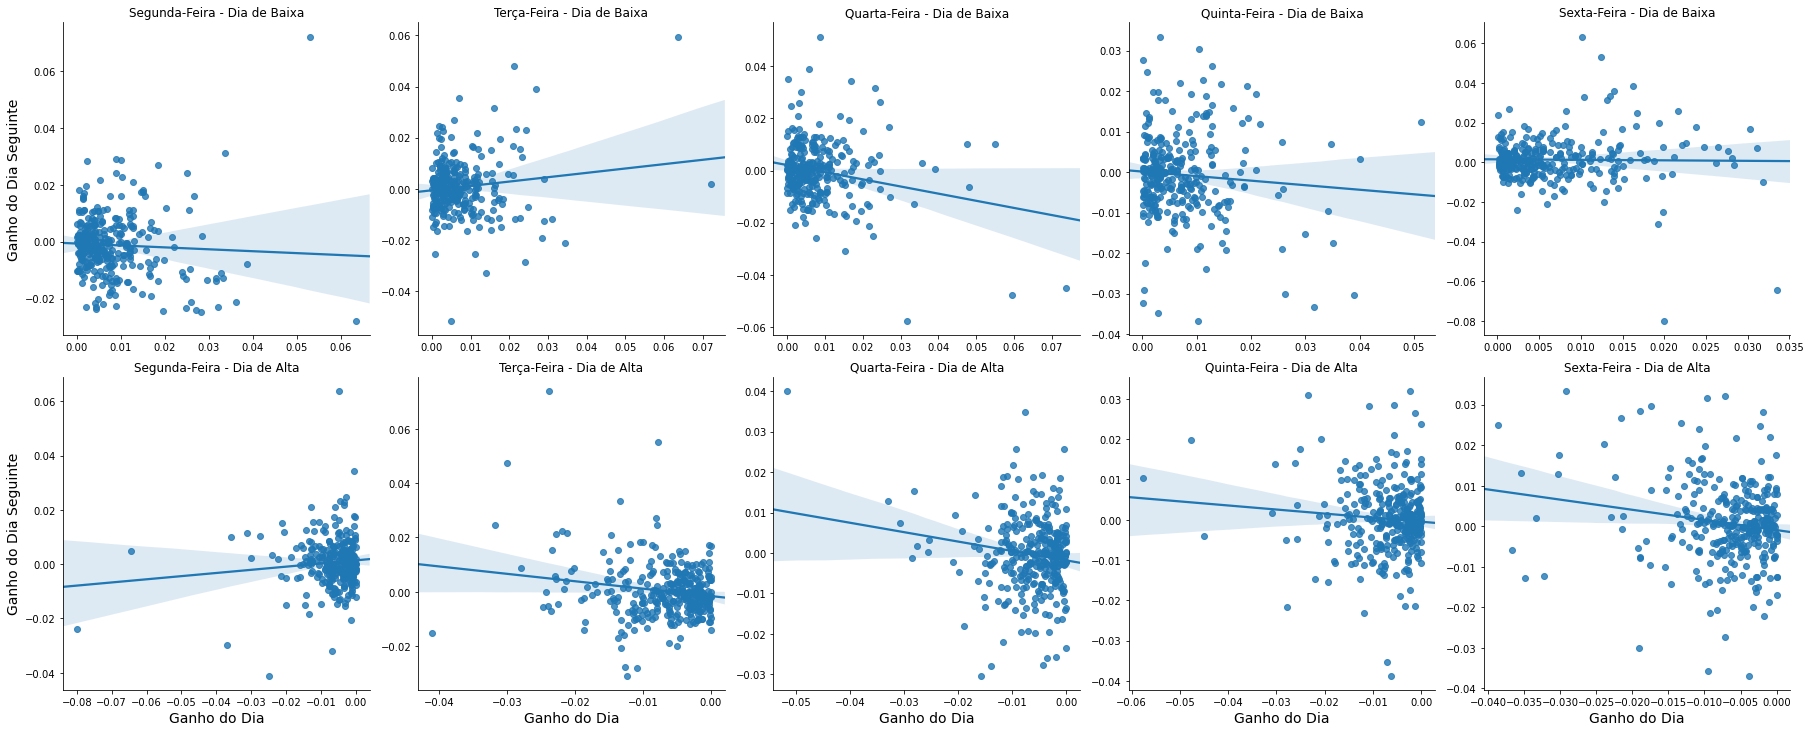

In [30]:
# Análise: Tendemos a uma reversão
days = ["2-Segunda", "3-Terça", "4-Quarta", "5-Quinta","6-Sexta"]
ax = sns.lmplot(x="ganhoDolar", y="ganhoFuturo",col='diasemananome', row='altabaixanome', palette="Set2", order=1, truncate=False, data=dataanalise, col_order=days, sharex=False, sharey=False)
ax.set_xlabels('Ganho do Dia', fontsize=14)
ax.set_ylabels('Ganho do Dia Seguinte', fontsize=14)
fig = ax.fig
a1 = fig.axes[0]; a1.set_title("Segunda-Feira - Dia de Baixa")
a1 = fig.axes[1]; a1.set_title("Terça-Feira - Dia de Baixa")
a1 = fig.axes[2]; a1.set_title("Quarta-Feira - Dia de Baixa")
a1 = fig.axes[3]; a1.set_title("Quinta-Feira - Dia de Baixa")
a1 = fig.axes[4]; a1.set_title("Sexta-Feira - Dia de Baixa")
a1 = fig.axes[5]; a1.set_title("Segunda-Feira - Dia de Alta")
a1 = fig.axes[6]; a1.set_title("Terça-Feira - Dia de Alta")
a1 = fig.axes[7]; a1.set_title("Quarta-Feira - Dia de Alta")
a1 = fig.axes[8]; a1.set_title("Quinta-Feira - Dia de Alta")
a1 = fig.axes[9]; a1.set_title("Sexta-Feira - Dia de Alta")
ax.savefig("disrtibuicaoGanhosPorDia.png")

## 7 - Feature Engineering

### 7.1 - Criando o Alvo

In [31]:
# data = data.drop(['comprarVender'], axis=1)
data.insert(21, 'comprarVender', 0)

In [32]:
data["comprarVender"] = 0

In [33]:
# AJUSTE DO ALVO
vendaQ_maior = np.percentile(data.ganhoDolar, 40) # Percentil de 40% dos dados
compraQ_maior = np.percentile(data.ganhoDolar, 60) # Percentil de 60% dos dados
# Setar alvo como Comprar(1) para todos os dias em que o percentual de retorno foi positivo
# Setar alvo como Vender(-1) para todos os dias em que o percentual de retorno foi negativo
# Setar alvo como Não Operar(0) para todos os dias em que o percentual de retorno for entre 40% e 60% da distribuição
data["comprarVender"] = np.where(data.ganhoFuturo > compraQ_maior , 1, np.where(data.ganhoFuturo < vendaQ_maior, -1, 0))
# Ajustar os dados de acordo com a análise distribuição das compras/vendas e maiores retornos
# Setar alvo como Comprar para toda segunda-feira positiva, compra 
data["comprarVender"] = np.where((data.diasemananome=='6-Sexta') & (data.ganhoFuturo >=  0), 1, data.comprarVender)
# Setar alvo como Vender para toda sexta-feira com retorno negativo, venda 
data["comprarVender"] = np.where((data.diasemananome=='5-Quinta') & (data.ganhoFuturo <= 0), -1, data.comprarVender)

In [34]:
data.groupby(['comprarVender'])['dolar_close'].count()

comprarVender
-1    1919
 0     716
 1    1923
Name: dolar_close, dtype: int64

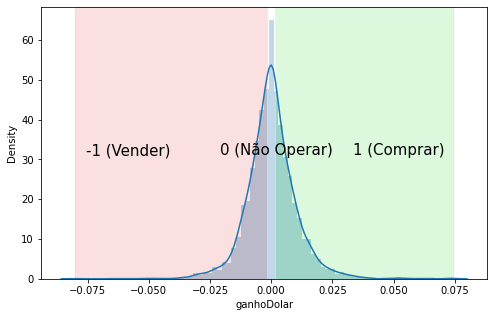

In [35]:
##### Gráfico da distribuição dos dias que foram de Compra, Venda e Náo operar Inicialmente
fig, ax = plt.subplots(figsize=(8,5))
sns.distplot(data.ganhoDolar, bins= 80).set()
ax.axvspan(vendaQ_maior, np.percentile(data.ganhoDolar, 0) , color='#EF9A9A', alpha=0.3)
ax.axvspan(compraQ_maior, np.percentile(data.ganhoDolar, 100) , color='lightgreen', alpha=0.3)
ax.axvspan(compraQ_maior, vendaQ_maior, color='white', alpha=0.3)
ax.text(0.4, 0.5, "0 (Não Operar)", ha="left", va="top", transform=ax.transAxes, fontsize = 15)
ax.text(0.1, 0.5, "-1 (Vender)", ha="left", va="top", transform=ax.transAxes, fontsize = 15)
ax.text(0.7, 0.5, "1 (Comprar)", ha="left", va="top", transform=ax.transAxes, fontsize = 15)
plt.savefig("distribuicaoComprarVenderInicial.png")

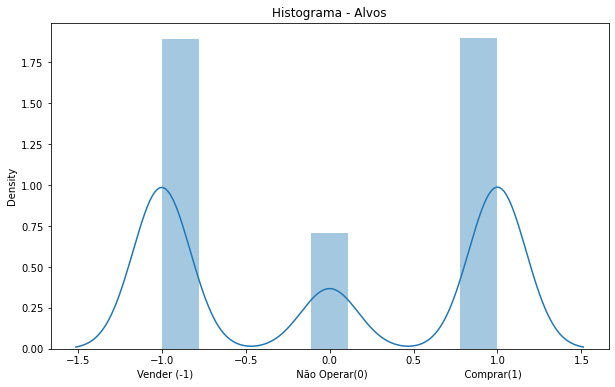

In [36]:
# Gráfico da distribuição das Compras, Vendas e Não Operar
plt.figure(figsize = (10,6))
sns.distplot(data.comprarVender).set(xlabel='Vender (-1)                                 Não Operar(0)                               Comprar(1)', title='Histograma - Alvos')
plt.savefig("distribuicaoComprarVenderOtimizada.png")

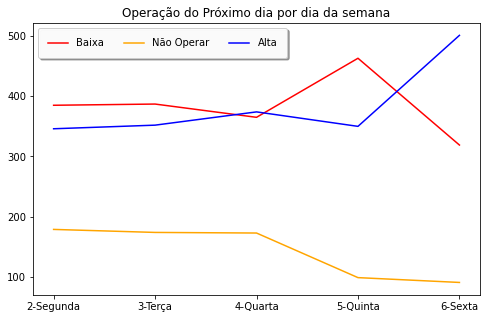

In [37]:
plt.figure(figsize = (8,5))
plt.plot(pd.crosstab(data.diasemananome, data.comprarVender))
plt.gca().get_lines()[0].set_color("red")
plt.gca().get_lines()[1].set_color("orange")
plt.gca().get_lines()[2].set_color("blue")
plt.legend(('Baixa', 'Não Operar', 'Alta'),loc = "upper left", frameon = True, ncol = 3, fancybox = True, framealpha = 0.95, shadow = True, borderpad = 1)
plt.title("Operação do Próximo dia por dia da semana");
plt.savefig("distribuicaoComprarDia.png")

### 7.2 - Criando novas variáveis

In [38]:
lags = 3
# Calculando o retorno simples do Ativo
for lag in range(1, lags+1, 1):
    data["retornodolar"+str(lag)] = data.variacaodolar.shift(lag)
    data["retornodxy"+str(lag)] = data.variacaodxy.shift(lag)
    data["retornoibov"+str(lag)] = data.variacaoibov.shift(lag)
    data["retornovix"+str(lag)] = data.variacaovix.shift(lag)

# Calculando o retorno acumulado do Ativo
for lag in range(2, lags+1, 1):
    data["retornodolarACC"+str(lag)] = data.dolar_close.pct_change(lag)
    data["retornodxyACC"+str(lag)] = data.variacaodxy.pct_change(lag)
    data["retornoibovACC"+str(lag)] = data.variacaoibov.pct_change(lag)
    data["retornovixACC"+str(lag)] = data.variacaovix.pct_change(lag)

In [39]:
# Calculando a direção dos último 3 dias - (1) Alta e (-1) Baixa
data["dir_dolarD1"] = np.where(data.dolar_close > data.dolar_close.shift(1), 1, 0)
data["dir_dxyD1"] = np.where(data['dxy_close'] > data['dxy_close'].shift(1) , 1, 0)
data["dir_ibovD1"] = np.where(data['ibov_close'] > data['ibov_close'].shift(1), 1, 0)
data["dir_vixD1"] = np.where(data['vix_close'] > data['vix_close'].shift(1), 1, 0)
data["dir_dolarD1"] = data["dir_dolarD1"].astype(int)
data["dir_dxyD1"] = data["dir_dxyD1"].astype(int)
data["dir_ibovD1"] = data["dir_ibovD1"].astype(int)
data["dir_vixD1"] = data["dir_vixD1"].astype(int)
for x in range(lags):
    data["dir_dolarD"+ str(x+1)] = data["dir_dolarD1"].shift(x)
    data["dir_dxyD"+ str(x+1)] = data["dir_dxyD1"].shift(x)
    data["dir_ibovD"+ str(x+1)] = data["dir_ibovD1"].shift(x)
    data["dir_vixD"+ str(x+1)] = data["dir_vixD1"].shift(x)
    


In [40]:
# Calculando a volatilidade do Ativo
for x in [5,10,15,120]:
    data["Voldolar"+str(x)] = data.dolar_close.rolling(x).std()*(252**0.5)
    data["Voldxy"+str(x)] = data.dxy_close.rolling(x).std()*(252**0.5)
    data["Volibov"+str(x)] = data.ibov_close.rolling(x).std()*(252**0.5)
    data["Volvix"+str(x)] = data.vix_close.rolling(x).std()*(252**0.5)


In [41]:
# Calculando o Indicador Técnico - Bandas de Bollinger  
for x in [10,20,30,50]:
    upperband, middleband, lowerband = talib.BBANDS(data.dolar_close, timeperiod=x, nbdevup=2, nbdevdn=2, matype=0)
    data["BBdolar"+str(x)] = np.where(data.dolar_close > middleband, 1, 0)
    upperband, middleband, lowerband = talib.BBANDS(data.dxy_close, timeperiod=x, nbdevup=2, nbdevdn=2, matype=0)
    data["BBdxy"+str(x)] = np.where(data.dxy_close > middleband, 1, 0)
    upperband, middleband, lowerband = talib.BBANDS(data.vix_close, timeperiod=x, nbdevup=2, nbdevdn=2, matype=0)
    data["BBvix"+str(x)] = np.where(data.vix_close > middleband, 1,0)
    upperband, middleband, lowerband = talib.BBANDS(data.ibov_close, timeperiod=x, nbdevup=2, nbdevdn=2, matype=0)
    data["BBibov"+str(x)] = np.where(data.ibov_close > middleband, 1, 0)

# Calculando o Indicador Técnico - MACD
fast = 12; slow = 26; signal=9
macd, macdsignal, macdhist = talib.MACD(data.dolar_close, fastperiod=fast, slowperiod=slow, signalperiod=signal)
data['macd'] = np.where(macdsignal > macd, 1, 0)
macddxy, macdsignaldxy, macdhist = talib.MACD(data.dxy_close, fastperiod=fast, slowperiod=slow, signalperiod=signal)
data['macddxy'] = np.where(macdsignaldxy > macddxy, 1, 0)
macdibov, macdsignalibov, macdhist = talib.MACD(data.ibov_close, fastperiod=fast, slowperiod=slow, signalperiod=signal)
data['macdibov'] = np.where(macdsignalibov > macdibov, 1, 0)
macdvix, macdsignalvix, macdhist = talib.MACD(data.vix_close, fastperiod=fast, slowperiod=slow, signalperiod=signal)
data['macdvix'] = np.where(macdsignalvix > macdvix, 1, 0)

# Calculando o Indicador Técnico - RSI
data['RSIdolar'] = talib.RSI(data.dolar_close, 14)
data['RSIdxy'] = talib.RSI(data.dxy_close, 14)
data['RSIvix'] = talib.RSI(data.vix_close, 14)
data['RSIibov'] = talib.RSI(data.ibov_close, 14)

# Calculando o Indicador Técnico - EMA - Média Móvel Exponencial
for x in [2,5,15,30, 120]:
    data["EMAdolar"+str(x)] = talib.EMA(data.dolar_close, timeperiod=x)/data.dolar_close
    data["EMAdxy"+str(x)] = talib.EMA(data.dxy_close, timeperiod=x)/data.dxy_close
    data["EMAvix"+str(x)] = talib.EMA(data.vix_close, timeperiod=x)/data.vix_close
    data["EMAibov"+str(x)] = talib.EMA(data.ibov_close, timeperiod=x)/data.ibov_close    

In [42]:
# Relação entre o tamanho do candle(fechamento menos abertura) e o valor de fechamento
data["dolar_CO"] = (data.dolar_close - data.dolar_open)/data.dolar_close - 1 
data["dxy_CO"] = (data.dxy_close - data.dxy_open)/data.dxy_close - 1  
data["ibov_CO"] = (data.ibov_close - data.ibov_open)/data.ibov_close - 1 
data["vix_CO"] = (data.vix_close - data.vix_open)/data.vix_close - 1 

# Relação entre o valor de abertura menos valor máximo e o valor de abertura
data["dolar_OH"] = (data.dolar_open - data.dolar_high)/data.dolar_open - 1
data["dxy_OH"] = (data.dxy_open - data.dxy_high)/data.dxy_open - 1
data["ibov_OH"] = (data.ibov_open - data.ibov_high)/data.ibov_open - 1
data["vix_OH"] = (data.vix_open - data.vix_high)/data.vix_open - 1

# Relação entre o valor de abertura menos valor mínimo e o valor de abertura
data["dolar_OL"] = (data.dolar_open - data.dolar_low)/data.dolar_open  - 1
data["dxy_OL"] = (data.dxy_open - data.dxy_low)/data.dxy_open - 1
data["ibov_OL"] = (data.ibov_open - data.ibov_low)/data.ibov_open - 1
data["vix_OL"] = (data.vix_open - data.vix_low)/data.vix_open - 1

# Relação entre o valor de fechamento menos valor máximo e o valor de fechamento
data["dolar_CH"] = (data.dolar_close - data.dolar_high)/data.dolar_close  - 1
data["dxy_CH"] = (data.dxy_close - data.dxy_high)/data.dxy_close - 1 
data["ibov_CH"] = (data.ibov_close - data.ibov_high)/data.ibov_close - 1  
data["vix_CH"] = (data.vix_close - data.vix_high)/data.vix_close - 1  

# Relação entre o valor de fechamento menos valor mínimo e o valor de fechamento
data["dolar_CL"] = (data.dolar_close - data.dolar_low)/data.dolar_close - 1 
data["dxy_CL"] = (data.dxy_close - data.dxy_low)/data.dxy_close - 1 
data["ibov_CL"] = (data.ibov_close - data.ibov_low)/data.ibov_close  - 1 
data["vix_CL"] = (data.vix_close - data.vix_low)/data.vix_close  - 1 

# Foi utilizada a função qcut da biblioteca Pandas para divisão dos resultados das variáveis em 5 partes, quintiles, transformando as variáveis numéricas em categóricas.
cut = 5
data["dolar_CO"] = pd.qcut(data["dolar_CO"], cut, labels = False)
data["dolar_OH"] = pd.qcut(data["dolar_OH"], cut, labels = False)
data["dolar_OL"] = pd.qcut(data["dolar_OL"], cut, labels = False)
data["dolar_CH"] = pd.qcut(data["dolar_CH"], cut, labels = False)
data["dolar_CL"] = pd.qcut(data["dolar_CL"], cut, labels = False)

data["dxy_CO"] = pd.qcut(data["dxy_CO"], cut, labels = False)
data["dxy_OH"] = pd.qcut(data["dxy_OH"], cut, labels = False)
data["dxy_OL"] = pd.qcut(data["dxy_OL"], cut, labels = False)
data["dxy_CH"] = pd.qcut(data["dxy_CH"], cut, labels = False)
data["dxy_CL"] = pd.qcut(data["dxy_CL"], cut, labels = False)

data["ibov_CO"] = pd.qcut(data["ibov_CO"], cut, labels = False)
data["ibov_OH"] = pd.qcut(data["ibov_OH"], cut, labels = False)
data["ibov_OL"] = pd.qcut(data["ibov_OL"], cut, labels = False)
data["ibov_CH"] = pd.qcut(data["ibov_CH"], cut, labels = False)
data["ibov_CL"] = pd.qcut(data["ibov_CL"], cut, labels = False)

data["vix_CO"] = pd.qcut(data["vix_CO"], cut, labels = False)
data["vix_OH"] = pd.qcut(data["vix_OH"], cut, labels = False)
data["vix_OL"] = pd.qcut(data["vix_OL"], cut, labels = False)
data["vix_CH"] = pd.qcut(data["vix_CH"], cut, labels = False)
data["vix_CL"] = pd.qcut(data["vix_CL"], cut, labels = False)

In [43]:
# Calcula a proporção do candle e relação a máxima e mínima. Fechamento menos abertura 
# dividido pelo maior valor do dia menos o menor valor.
data["dolar_candle"] = (data.dolar_close - data.dolar_open)/ (data.dolar_high - data.dolar_low) -1
data["dxy_candle"] = (data.dxy_close - data.dxy_open)/ (data.dxy_high - data.dxy_low) -1
data["ibov_candle"] = (data.ibov_close - data.ibov_open)/ (data.ibov_high - data.ibov_low) -1
data["vix_candle"] = (data.vix_close - data.vix_open)/ (data.vix_high - data.vix_low) -1
# Calcula a relação entre a sombra do cande, pin, e o corpo do candle para cada ativo.
data["dolar_pin"] = (np.where(data.dolar_close > data.dolar_open, (data.dolar_open - data.dolar_low) / (data.dolar_close - data.dolar_open) -1, 
                              (data.dolar_high - data.dolar_open) / (data.dolar_open - data.dolar_close) -1) )
data["ibov_pin"] = (np.where(data.ibov_close > data.ibov_open, (data.ibov_open - data.ibov_low) / (data.ibov_close - data.ibov_open) -1, 
                             (data.ibov_high - data.ibov_open) / (data.ibov_open - data.ibov_close) -1) )
 
# Foi utilizada a função qcut da biblioteca Pandas para divisão dos resultados das variáveis em 5 partes, quintiles, 
# transformando as variáveis numéricas em categóricas.
cut = 5
data["dolar_candle"] = pd.qcut(data["dolar_candle"], cut, labels = False)
data["dxy_candle"] = pd.qcut(data["dxy_candle"], cut, labels = False)
data["ibov_candle"] = pd.qcut(data["ibov_candle"], cut, labels = False)
data["vix_candle"] = pd.qcut(data["vix_candle"], cut, labels = False)
data["dolar_pin"] = pd.qcut(data["dolar_pin"], cut, labels = False)
data["ibov_pin"] = pd.qcut(data["ibov_pin"], cut, labels = False, duplicates='drop')


In [44]:
data = data.replace([np.inf, -np.inf], 0)
data = data.dropna()

### 7.3 Normalizando as Variaveis

#### 7.3.1 Função de Normalização por Z-Score

In [45]:
#Função que normaliza os dados no padrão zScore. 
# Inputs -> df: Dataset e colunas: colunas a serem normalizadas
def z_score(df, colunas):
    for coluna in colunas:
        df[coluna] = (df[coluna] - df[coluna].mean())/df[coluna].std()
    return df;

#### 7.3.2 Função de Normalização entre -1 e 1

In [46]:
#Função que normaliza os dados na escala de -1 a 1
# Inputs -> df: Dataset e colunas: colunas a serem normalizadas
def escala(df, colunas):
    scaler = MinMaxScaler(feature_range = (-1,1))
    for i in colunas:
        df[i] = scaler.fit_transform(df[[i]])
    return df;

## 8 - Separando a base dados entre Treinamento e Teste

In [47]:
# Função que move uma coluna para outra posição no dataset
def mover_coluna(df, col, pos):
    col = df.pop(col)
    df.insert(pos, col.name, col)

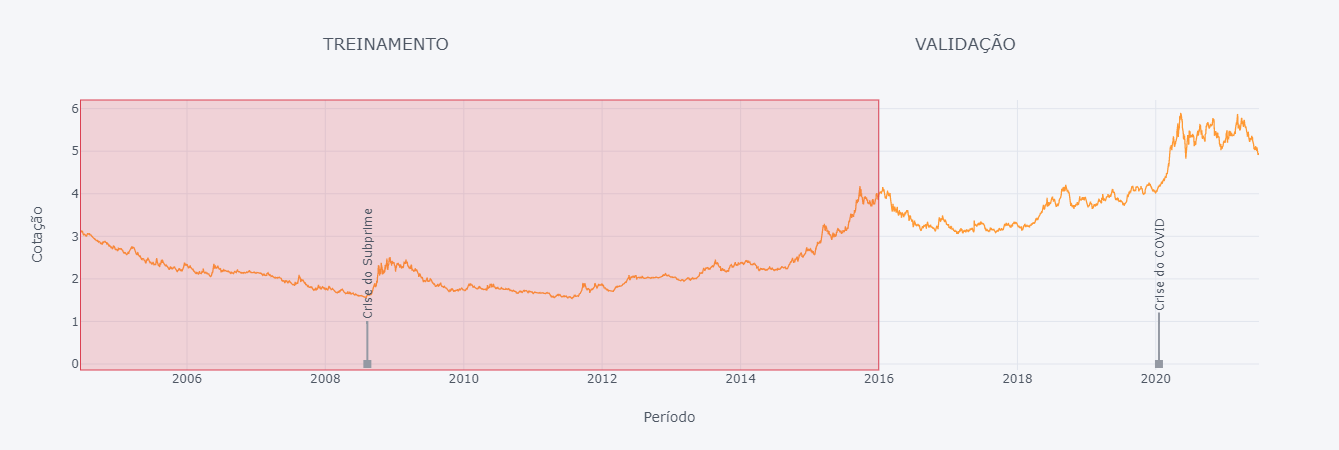

In [48]:
# Função que divide a base de dados entre Treinamento e Teste
# Inputs:
#     dados: dataset 
#     coluna: Coluna que começa os dados a serem utilizados
#     normalizar: QUal função de normalização utilizar
#     inicioNorm: Coluna em que começará a normalização dos dados
#     inicioValidacao: Data de início do teste 
#     inicio_train: Data de início do treinamento
        
def criar_validacao_train(dados, coluna, normalizar, inicioNorm, datainicioValidacao, inicio_train):

    data_modelo = dados.iloc[:, coluna : dados.shape[1]]

    # Excluindo os dados faltantes
    data_modelo = data_modelo.dropna()
    mover_coluna(data_modelo, 'PontosDia', 20) 
    data_inicial =  data_modelo.first_valid_index()  
    data_final = data_modelo.last_valid_index() 

    if not inicio_train :
        inicio_train = data_inicial
        
    fim_train = pd.to_datetime(datainicioValidacao) + datetime.timedelta(days=-1)
    inicio_teste = pd.to_datetime(datainicioValidacao)
    fim_teste = data_final

    # Dividindo os dados entre treinamento e teste
    data_modelo_train = data_modelo[inicio_train : fim_train]
    data_modelo_validacao = data_modelo[inicio_teste : fim_teste]
    
    # normalizando os dados
    colunas_filtro = data_modelo_train.iloc[:, inicioNorm : data_modelo_train.shape[1]].columns
    if normalizar == 'escala':
        data_modelo_train = escala(data_modelo_train, colunas_filtro);
    elif normalizar == 'z-score':
        data_modelo_train = z_score(data_modelo_train, colunas_filtro)
    
    #Gráfico que demonstra a divisão de treinamento e teste da série temporal
    anotacoes = {pd.to_datetime('2008-08-10'): 'Crise do Subprime', pd.to_datetime('2020-01-18'): 'Crise do COVID'}
    fig = data.dolar_close.iplot(kind='line',xTitle='Período',yTitle='Cotação',
                                 title='TREINAMENTO                                                                              VALIDAÇÃO',
                            annotations=anotacoes, vspan=[dict(x0=inicio_train, x1=inicio_teste, color= 'red', fill= 'red', opacity=0.2)])

    return data_modelo, data_modelo_train, data_modelo_validacao;

ini_train = ''
data_modelo, data_modelo_train, data_modelo_validacao = criar_validacao_train(data, 21, "escala", 3, inicioValidacao, ini_train)

## 9 - Aplicando Modelo de Machine Learning

In [49]:
# Definindo como o Pycaret irá aplicar os modelos.
stpTrain = setup(data_modelo_train, target="comprarVender", session_id=20, experiment_name="TCC")


In [50]:
# Define o dataframe modeloinfo que receberá todos os modelos e suas métricas para comparação
colunas = ['nome', 'tunar', 'otimizar', 'f1_score', 'accuracy', 'accuracyTrain', 'accuracyTest', 'pred', 'modelo', 'inicio_teste', 'fim_teste', 'retornoQuantMin', 'retornoBHMin', 
                                   'retornoQuantMax', 'retornoBHMax', 'drawdownQuant', 'drawdownBH', 'quant', 'bh']
modeloinfo = pd.DataFrame(columns=colunas)

# Capital inicial do investimento
kpital = 1000

In [51]:
import pickle

# Insere os dados no modeloinfo, calcula métricas, executa a função calculaPontos e drawdown.
def perform(nome, tunar, otimizar, tunado_pull, predito_pull, modelo, inicio_teste, fim_teste, kpital):
    
    info = pd.DataFrame(columns=colunas)
    acctuned = round((tunado_pull['Accuracy']['Mean']*100), 2)
    acc_f_tuned = round((predito_pull['Accuracy'][0]*100), 2)
    
    pred = predict_model(modelo, data = data_modelo_validacao)
    acc = round(check_metric(pred['comprarVender'], pred['Label'], metric = 'Accuracy')*100, 2)    
    f1score = f1_score(pred['comprarVender'], pred['Label'], average='macro')
    
    pred['aleatorio'] = 0
    pred['aleatorio'] = pred['aleatorio'].apply(lambda x: np.random.choice([-1, 0, 1], 1)[0])

    pred = calculaPontos(pred, inicio_teste, fim_teste)

    ddquant = metricasFinanceiras(pred.retorno, kpital).round(2)
    ddbh = metricasFinanceiras(pred.ganhoDolar, kpital).round(2)
    ddrnd = metricasFinanceiras(pred.retornoAleatorio, kpital).round(2) 

    return (
        {
         'nome': nome, 'tunar': tunar, 'otimizar': otimizar, 'f1_score': f1score, 'accuracy': acc, 'accuracyTrain': acctuned, 'accuracyTest': acc_f_tuned,
         'pred': pickle.dumps(pred), 'modelo': pickle.dumps(modelo), 'inicio_teste': inicio_teste,'fim_teste': fim_teste, 
         'retornoQuantMin': ddquant.investimento.min(), 'retornoBHMin': ddbh.investimento.min(), 'retornoQuantMax': ddquant.investimento.max(), 
         'retornoBHMax':ddbh.investimento.max(), 'drawdownQuant':ddquant.drawdown.min(), 'drawdownBH':ddbh.drawdown.min(), 'quant': pickle.dumps(ddquant), 'bh': pickle.dumps(ddbh), 'rnd': pickle.dumps(ddrnd)
        })

# Calcula o retorno do investimento de acordo com a predição realizada no dataframe de validação.
def calculaPontos(prediction, inicio_teste, fim_teste):
    prediction['dolar_close']= data[inicio_teste :fim_teste ]['dolar_close']
    prediction['ganhoFuturo'] = data[ inicio_teste: fim_teste]['ganhoFuturo']
    prediction['ganhoDolar']= data[ inicio_teste: fim_teste]['ganhoDolar']
    prediction['Pontos']= data[inicio_teste : fim_teste]['Pontos']
    prediction['altaBaixaFuturo'] = np.where(prediction.ganhoFuturo > 0 , 1, -1)
    
    prediction["Ret_Pontos"]= np.where(prediction.Label == 1 , prediction.Pontos, 0)
    prediction["Ret_Pontos"] = np.where(prediction.Label == -1 , -1*prediction.Pontos, prediction.Ret_Pontos)
    prediction["Ret_Pontos"] = prediction["Ret_Pontos"].astype(float)
    prediction["Ret_Pontos_acu"] = prediction["Ret_Pontos"].cumsum()

    prediction["retorno"]= np.where(prediction.Label == 1 , prediction.ganhoFuturo, 0)
    prediction["retorno"] = np.where(prediction.Label == -1 , -1*prediction.ganhoFuturo, prediction.retorno)
    
    prediction["retornoAleatorio"]= np.where(prediction.aleatorio == 1 , prediction.ganhoFuturo, 0)
    prediction["retornoAleatorio"] = np.where(prediction.aleatorio == -1 , -1*prediction.ganhoFuturo, prediction.retornoAleatorio)
    
    return prediction
    
# Calcula o valor gerado pelo investimento, o drawdown do investimento e seu maior retorno. 
def metricasFinanceiras(retorno, kpital):
    investimento= kpital*(1+retorno).cumprod()
    ultimaalta=investimento.cummax()
    drawdown=((investimento-ultimaalta)/ultimaalta)*100
    
    return pd.DataFrame({
        "retorno": retorno,
        "investimento": investimento,
        "ultimaalta": ultimaalta,
        "drawdown": drawdown
    })

# Imprime o gráfico do investimento com o valor do buy and hold, outra linha com o valor investido do modelo e outro aleatório para comparação.
def analisarGraf(quant, bh, kpital):

    # Preparando investimento aleatorio
    rnd = pd.DataFrame(index=quant.index)
    rnd['retorno'] = quant['retorno']
    rnd['aleatorio'] = 0
    rnd['aleatorio'] = rnd['aleatorio'].apply(lambda x: np.random.choice([-1, 0, 1], 1)[0])
    rnd["retornoAleatorio"]= np.where(rnd.aleatorio == 1 , rnd.retorno, 0)
    rnd["retornoAleatorio"] = np.where(rnd.aleatorio == -1 , -1*rnd.retorno, rnd.retornoAleatorio)
    retornoAleatorio = round(metricasFinanceiras(rnd["retornoAleatorio"], kpital),2)
    
    anotacoes = {pd.to_datetime('2019-04-06'): 'Crise do COVID'}
    quant = quant.rename(columns={'investimento':'investimento_modelo', 'drawdown': 'drawdown_modelo', 'retorno':'ganhoDolar'})
    bh = bh.rename(columns={'investimento':'investimento_buynHold', 'drawdown': 'drawdown_buynHold'})
    retornoAleatorio = retornoAleatorio.rename(columns={'investimento':'investimento_Aleatorio', 'drawdown': 'drawdown_Aleatorio'})
    
    db = quant.merge(bh, on='Date', how='left')
    db = db.merge(retornoAleatorio, on='Date', how='left')  
    
    db['dd_modelo_media'] = db['drawdown_modelo'].rolling(252).mean()
    db['dd_bh_media'] = db['drawdown_buynHold'].rolling(252).mean()
    
    db[['investimento_modelo', 'investimento_buynHold', 'investimento_Aleatorio']].iplot(kind='spread',xTitle='Período',yTitle='Capital',title='Curva do Capital Investido',
                                                             annotations=anotacoes)

    db[['drawdown_modelo', 'drawdown_buynHold', 'dd_bh_media', 'dd_modelo_media']].iplot(kind='spread',xTitle='Período',yTitle='Drawdown',title='Drawdown do Investimento',
                                                                                            color=['orange', 'blue', 'blue' , 'orange'])
    
    return db

In [52]:
# Cria e faz o tunning dos modelos e insere no modeloinfo
cross = 10
iterat = 10
tunar = True
otimizar = 'Accuracy'
fimValidacao = data.last_valid_index()

modelos = ['et', 'dt', 'lightgbm'] 

for nome in modelos:
    if tunar:  
        modelo = create_model(nome, cross_validation = False)
        tmodelo = tune_model(modelo, optimize = otimizar, fold = cross, n_iter = iterat) 
        modelo_pull = pull()
    else:
        modelo = create_model(nome, fold = cross)
        modelo_pull = pull()
        tmodelo = modelo

    fmodelo = finalize_model(tmodelo)
    predict_model(fmodelo)
    pmodelo_pull = pull()
    
    analise = perform(nome, tunar, otimizar, modelo_pull, pmodelo_pull, fmodelo, inicioValidacao, fimValidacao, kpital)
    modeloinfo = modeloinfo.append(analise, ignore_index=True)

### 9.1 - Resultados

In [53]:
# Renomeia as colunas do dataframe para nomes mais amigáveis
modeloinfo= modeloinfo.rename(columns={'nome': 'Nome Modelo', 'accuracy': 'Acurácia - Validação', 'accuracyTrain': 'Acurácia - Treinamento', 'accuracyTest': 'Acurácia - Teste', 'retornoQuantMax': 'Retorno Máximo Modelo', 'retornoBHMax': 'Retorno Máximo Buy and Hold', 'drawdownQuant': 'Drawdown do Modelo', 'drawdownBH': 'Drawdown do Buy and Hold', 'retornoQuantMin': 'Retorno Mínimo do Modelo', 'retornoBHMin': 'Retorno Mínimo do Buy and Hold'})

In [69]:
# Comparando os modelos
modeloinfo.sort_values(by=['Nome Modelo'], ascending=False)[['Nome Modelo','Acurácia - Treinamento', 'Acurácia - Teste','Acurácia - Validação','Retorno Máximo Modelo', 'Retorno Máximo Buy and Hold', 'Drawdown do Modelo','Drawdown do Buy and Hold', 'Retorno Mínimo do Modelo','Retorno Mínimo do Buy and Hold']].transpose()

2       0       1
Nome Modelo                     lightgbm      et      dt
Acurácia - Treinamento             44.36   45.51   44.17
Acurácia - Teste                   69.02   48.43   48.32
Acurácia - Validação               45.38   47.30   45.23
Retorno Máximo Modelo            1999.09 2399.58 1689.57
Retorno Máximo Buy and Hold      1490.61 1490.61 1490.61
Drawdown do Modelo                -23.39  -23.89  -28.91
Drawdown do Buy and Hold          -26.46  -26.46  -26.46
Retorno Mínimo do Modelo          819.60  997.39  967.25
Retorno Mínimo do Buy and Hold    771.94  771.94  771.94

In [55]:
# Alterar o Modelo através do array modeloinfo -> 0 1 2
# Descomentar apenas a linha que quer para ver os gráficos e métricas
modelo = pickle.loads(modeloinfo.iloc[0]['modelo'])
evaluate_model(modelo) # Mostra todas as métricas do Pycaret
# interpret_model(modelo)#, save=True) # Mostra as Variáveis mais Importantes - Shapley value
# interpret_model(modelo, plot = 'reason', observation = 10)#, save=True) # Mostra o motivo de determinada classificação - Shapley value
# plot_model(modelo, plot="confusion_matrix")#, save=True);

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

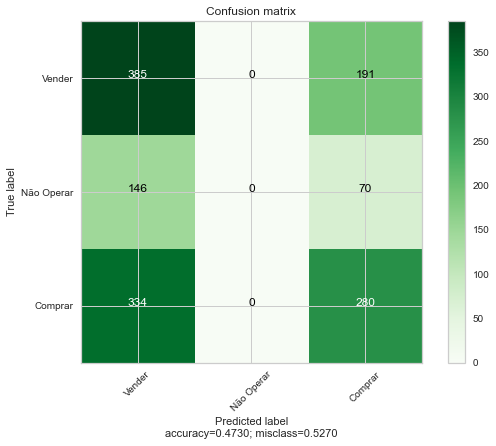

In [60]:
# Imprima a Matriz de Confusão d
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Greens')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig("LGBM-CM.png")
    plt.show()
    
    
# Alterar o Modelo através do array modeloinfo -> 0 1 2
modelo = pickle.loads(modeloinfo.iloc[0]['pred'])

plot_confusion_matrix(confusion_matrix(modelo['comprarVender'], modelo['Label']),
                          ['Vender', 'Não Operar', 'Comprar'],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)

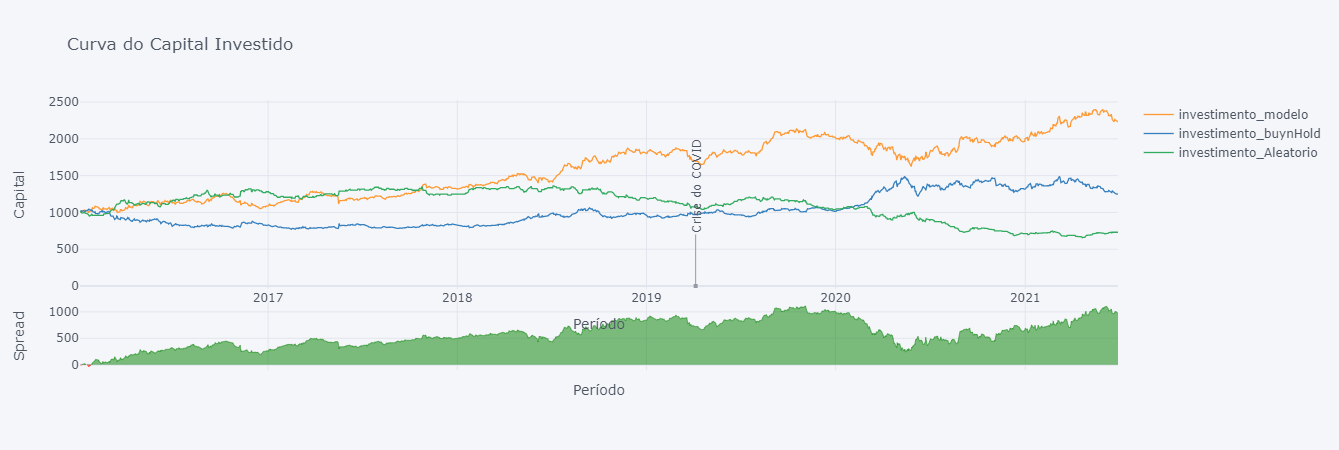

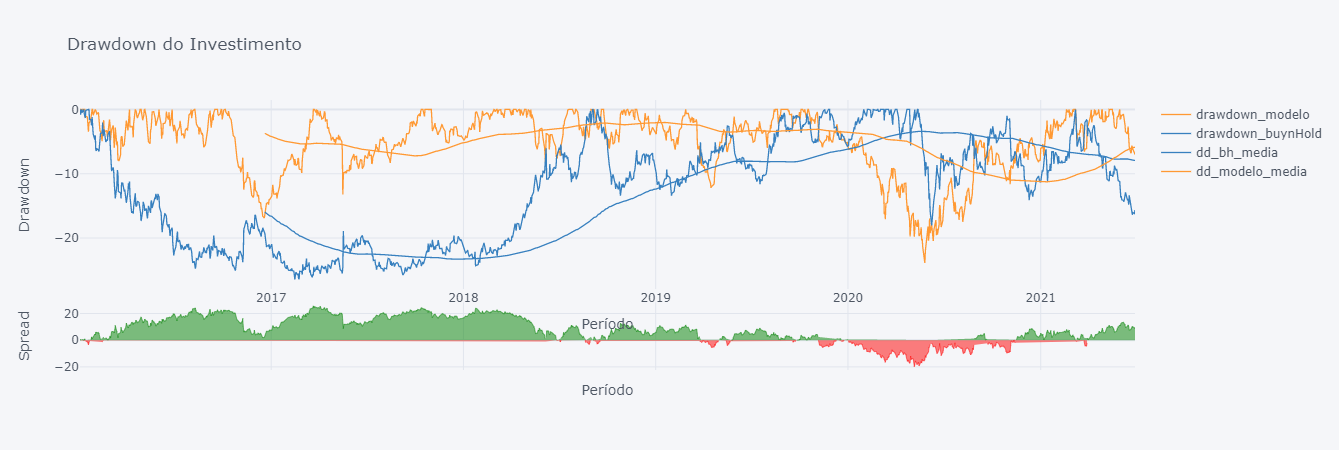

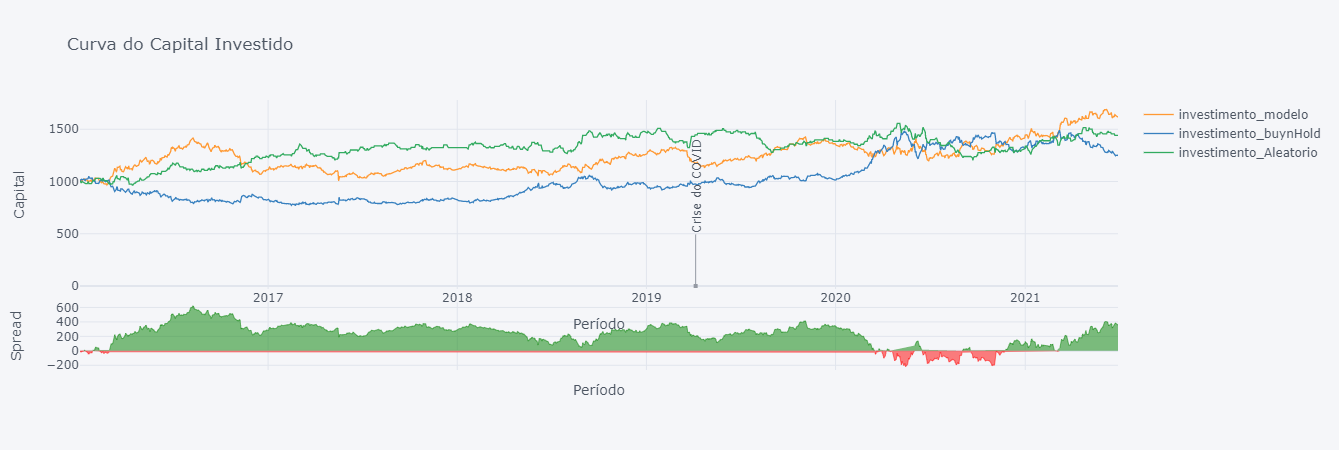

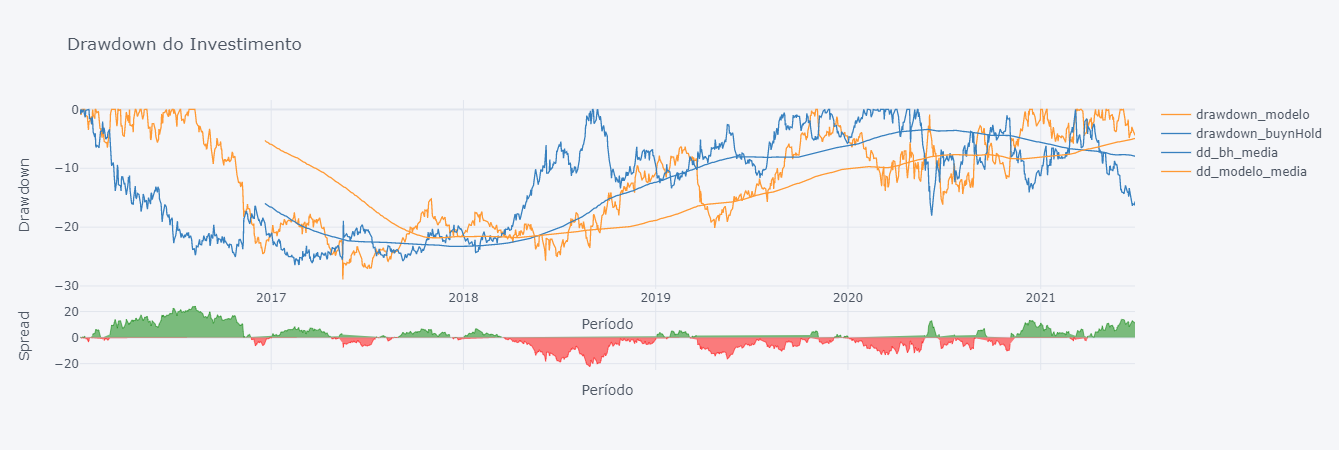

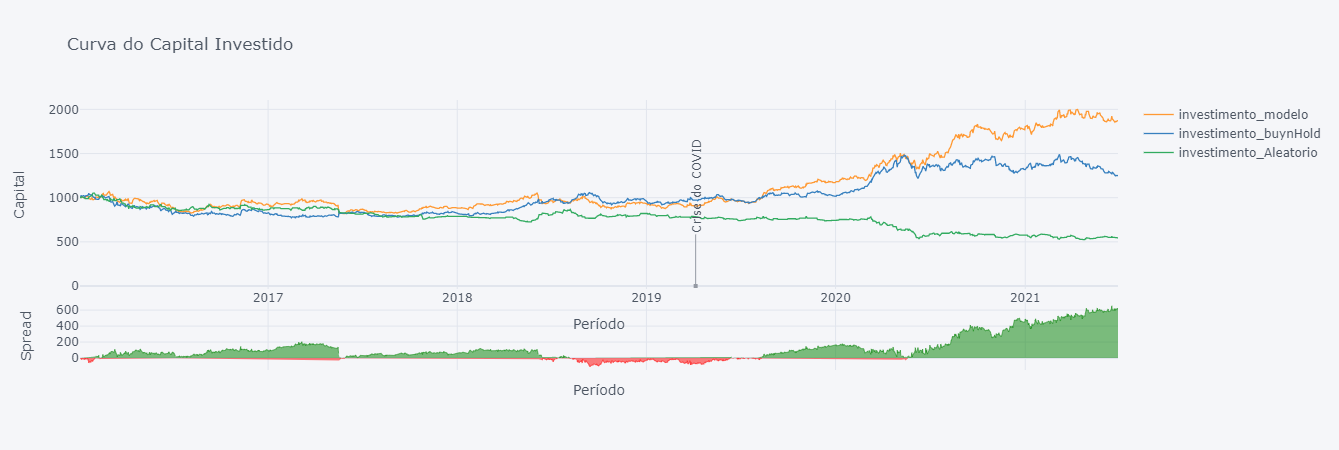

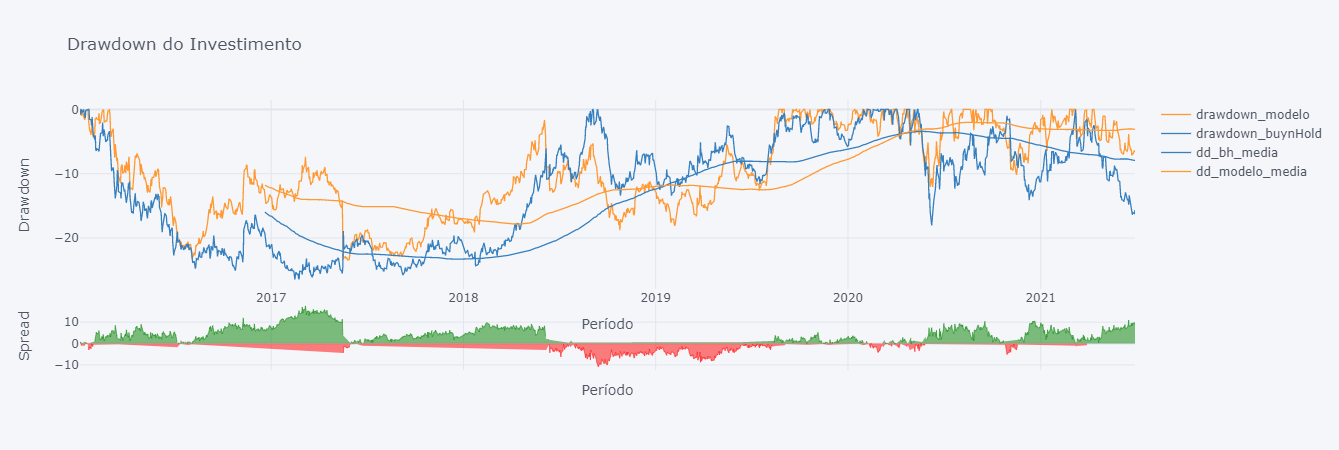

In [57]:
# GRÁFICO DOS MODELOS
mod = 0
quant = pickle.loads(modeloinfo.iloc[mod]['quant'])
bh = pickle.loads(modeloinfo.iloc[mod]['bh'])
db = analisarGraf(quant, bh, kpital)

mod = 1
quant = pickle.loads(modeloinfo.iloc[mod]['quant'])
bh = pickle.loads(modeloinfo.iloc[mod]['bh'])
db = analisarGraf(quant, bh, kpital)

mod = 2
quant = pickle.loads(modeloinfo.iloc[mod]['quant'])
bh = pickle.loads(modeloinfo.iloc[mod]['bh'])
db = analisarGraf(quant, bh, kpital)

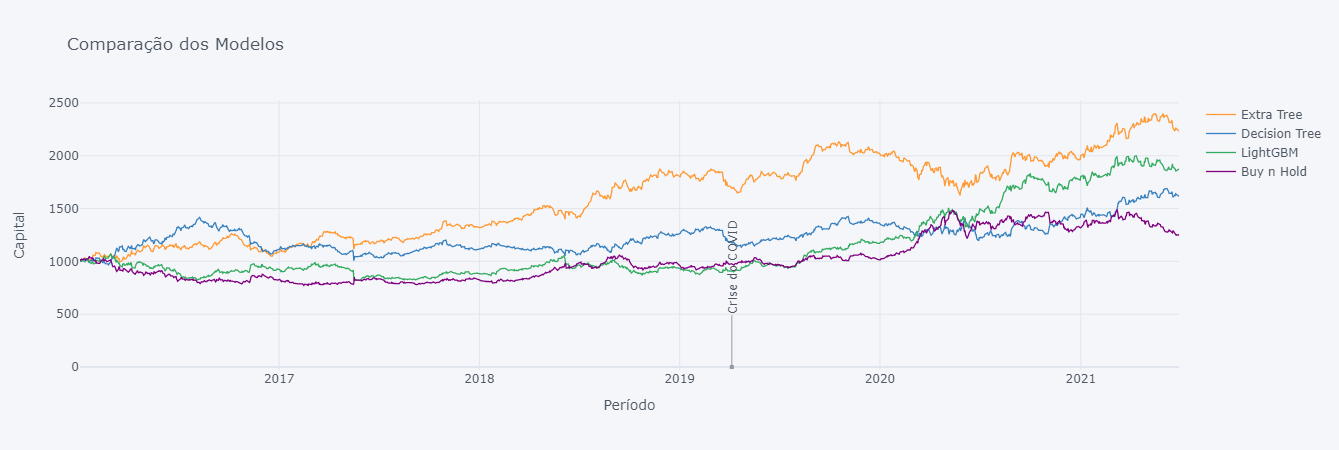

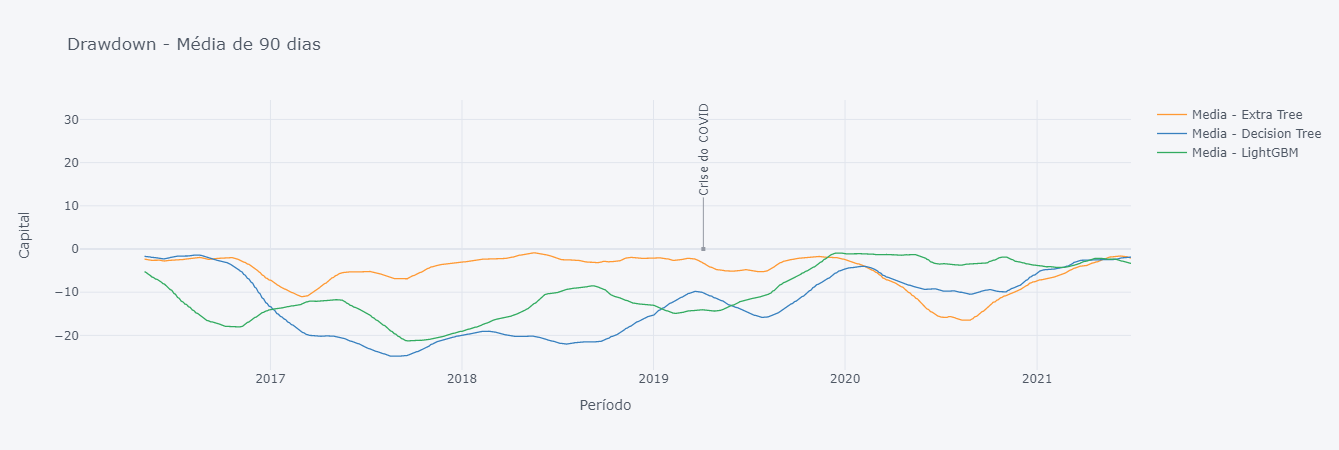

In [58]:
### GRAFICO DOS MODELOS JUNTOS
modelo0 = pickle.loads(modeloinfo.iloc[0]['quant'])  
modelo1 = pickle.loads(modeloinfo.iloc[1]['quant'])  
modelo2 = pickle.loads(modeloinfo.iloc[2]['quant'])   
bh = pickle.loads(modeloinfo.iloc[0]['bh'])

anotacoes = {pd.to_datetime('2019-04-06'): 'Crise do COVID'}
modelo0 = modelo0.rename(columns={'investimento':'Extra Tree', 'drawdown': 'Extra Tree - Drawdown', 'retorno':'ganhoDolar0'})
modelo1 = modelo1.rename(columns={'investimento':'Decision Tree', 'drawdown': 'Decision Tree - Drawdown', 'retorno':'ganhoDolar1'})
modelo2 = modelo2.rename(columns={'investimento':'LightGBM', 'drawdown': 'LightGBM - Drawdown', 'retorno':'ganhoDolar2'})
bh = bh.rename(columns={'investimento':'Buy n Hold', 'drawdown': 'Buy n Hold - Drawdown'})

db = modelo0.merge(modelo1, on='Date', how='left')
db = db.merge(modelo2, on='Date', how='left') 
db = db.merge(bh, on='Date', how='left') 


db[['Extra Tree', 'Decision Tree', 'LightGBM', 'Buy n Hold']].iplot(xTitle='Período',yTitle='Capital',title='Comparação dos Modelos',
                                                         annotations=anotacoes)

db['Media - Extra Tree'] = db['Extra Tree - Drawdown'].rolling(90).mean()
db['Media - Decision Tree'] = db['Decision Tree - Drawdown'].rolling(90).mean()
db['Media - Buy n Hold'] = db['Buy n Hold - Drawdown'].rolling(90).mean()
db['Media - LightGBM'] = db['LightGBM - Drawdown'].rolling(90).mean()

db[['Media - Extra Tree', 'Media - Decision Tree',  'Media - LightGBM' ]].iplot(xTitle='Período',yTitle='Capital',title='Drawdown - Média de 90 dias',
                                                         annotations=anotacoes)